In [63]:
%%capture
! pip install xclim

In [64]:
import xclim.sdba

In [65]:
import xesmf
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import rhg_compute_tools.kubernetes as rhgk

In [66]:
client, cluster = rhgk.get_micro_cluster()

In [68]:
cluster.scale(125)

In [ ]:
def read_gcs_zarr(zarr_url, token='/opt/gcsfuse_tokens/impactlab-data.json', check=False, consolidated=True):
    """
    takes in a GCSFS zarr url, bucket token, and returns a dataset 
    Note that you will need to have the proper bucket authentication. 
    """
    fs = gcsfs.GCSFileSystem(token=token)
    
    store_path = fs.get_mapper(zarr_url, check=check)
    
    ds = xr.open_zarr(store_path, consolidated=consolidated)
    
    ds.close()
    
    return ds 

# Diagnosing ERA-5 regridding with near-Seattle cells

In [2]:
# [-180, 180] -> [0, 360]
def lon360(lon180):
    return ((360 + (lon180 % 360)) % 360)

In [1]:
# vice versa
def lon180(lon360):
    if (lon360 > 180.0):
        return lon360 - 360.0
    else:
        return lon360

In [7]:
# load ERA-5 versions 
# ERA-5 "coarse" and "fine" (both at 1/4 degree) used in downscaling -- BEFORE wetday correction. 
pr_coarse_ref = read_gcs_zarr('gs://scratch-170cd6ec/6447567c-320f-4dea-ba65-8337b4376192/biascorrectdownscale-precipitation-jczlx-2742896890/rechunked.zarr')
pr_fine_ref = read_gcs_zarr('gs://scratch-170cd6ec/6447567c-320f-4dea-ba65-8337b4376192/biascorrectdownscale-precipitation-jczlx-1940554070/rechunked.zarr')
# ERA-5 at regular Gaussian resolution, "cleaned" by renaming variable/dims 
pr_cleaned_ref = read_gcs_zarr('gs://clean-b1dbca25/reanalysis/ERA-5/F320/pr.1995-2015.F320.zarr')
# ERA-5 at regular Gaussian resolution
pr_raw_ref = read_gcs_zarr('gs://impactlab-data/climate/source_data/ERA-5/downscaling/pr.1994-2015.F320.v5.zarr')
# define Seattle lat/lon 
target_lat = 47.608013
target_lon = -122.335167 

In [8]:
# now get Seattle timeseries from each of these ERA-5 versions.
# two of the datasets have [0,360] ranging longitude, need to convert. 
pr_seattle_pipeline = pr_cleaned_ref['pr'].sel(lon=lon360(target_lon), lat=target_lat, method="nearest").load()
pr_seattle_pipeline_coarse = pr_coarse_ref['pr'].sel(lon=target_lon, lat=target_lat, method="nearest").load()
pr_seattle_pipeline_fine = pr_fine_ref['pr'].sel(lon=target_lon, lat=target_lat, method="nearest").load()
pr_seattle_pipeline_raw = pr_raw_ref['tp'].sel(longitude=lon360(target_lon), latitude=target_lat, method="nearest").load()

In [124]:
pr_seattle_pipeline_wetday_corrected = pr_seattle_pipeline.where(
    pr_seattle_pipeline > 1.0, np.random.uniform(low=0.5, high=1.0)
)

Text(0.5, 1.0, 'Seattle annual precip')

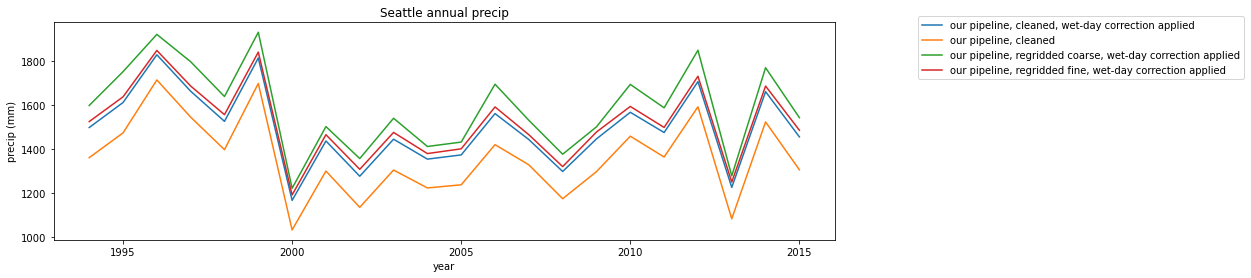

In [125]:
plt.figure(figsize=(14, 4))
pr_seattle_pipeline_wetday_corrected.groupby('time.year').sum().plot(label='our pipeline, cleaned, wet-day correction applied')
pr_seattle_pipeline.groupby('time.year').sum().plot(label='our pipeline, cleaned')
#pr_seattle_pipeline_raw.groupby('time.year').sum().plot(label='our pipeline, raw', linestyle=':')
pr_seattle_pipeline_coarse.groupby('time.year').sum().plot(label='our pipeline, regridded coarse, wet-day correction applied')
pr_seattle_pipeline_fine.groupby('time.year').sum().plot(label='our pipeline, regridded fine, wet-day correction applied')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.ylabel('precip (mm)')
plt.title('Seattle annual precip')

In [10]:
dict_of_da = {'cleaned':pr_seattle_pipeline, 
              'regridded_coarse':pr_seattle_pipeline_coarse,
              'regridded_fine':pr_seattle_pipeline_fine}

In [211]:
for key, da in dict_of_da.items():
    print(key)
    res = {
        'zeros_pct': da.where(da>=0.254).isnull().sum().values.item()/len(da.time.values),
        'min': da.min().compute().values.item(),
        'q1': da.quantile(0.01).compute().values.item(),
        'q10': da.quantile(0.10).compute().values.item(),
        'q50': da.quantile(0.5).compute().values.item(),
        'q90': da.quantile(0.10).compute().values.item(),
        'q99': da.quantile(0.99).compute().values.item(),
        'max': da.max().compute().values.item(),
        'mean': da.mean().compute().values.item(),
        'year_sum_min' : da.groupby('time.year').sum().min().compute().values.item(),
        'year_sum_mean' : da.groupby('time.year').sum().mean().compute().values.item(),
        'year_sum_max' : da.groupby('time.year').sum().max().compute().values.item()
    }
    for r in res:
        res[r] = round(res[r], 3)
    print(res)

cleaned
{'zeros_pct': 0.409, 'min': 0.0, 'q1': 0.0, 'q10': 0.0, 'q50': 0.833, 'q90': 0.0, 'q99': 30.693, 'max': 79.769, 'mean': 3.734, 'year_sum_min': 1034.107, 'year_sum_mean': 1362.967, 'year_sum_max': 1713.917}
regridded_coarse
{'zeros_pct': 0.0, 'min': 0.891, 'q1': 0.891, 'q10': 0.891, 'q50': 1.355, 'q90': 0.891, 'q99': 32.937, 'max': 77.529, 'mean': 4.525, 'year_sum_min': 1289.435, 'year_sum_mean': 1651.516, 'year_sum_max': 1986.646}
regridded_fine
{'zeros_pct': 0.0, 'min': 0.836, 'q1': 0.836, 'q10': 0.836, 'q50': 0.864, 'q90': 0.836, 'q99': 30.236, 'max': 79.602, 'mean': 4.088, 'year_sum_min': 1165.235, 'year_sum_mean': 1491.943, 'year_sum_max': 1823.364}


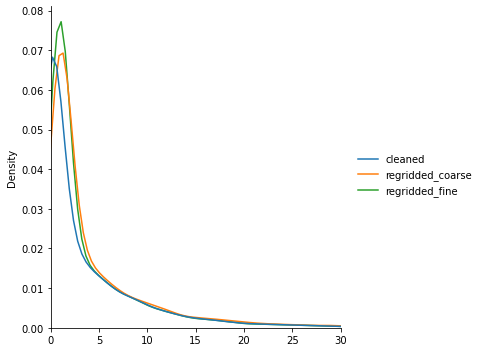

In [253]:
pl = seaborn.displot(dict_of_da, kind='kde')
pl.set(xlim=(0,30))

# Regridding tests with ERA-5 (bilinear)

In [165]:
# to regrid
ds_in = pr_cleaned_ref
ds_in

<xarray.Dataset>
Dimensions:  (lat: 640, lon: 1280, time: 8030)
Coordinates:
  * lat      (lat) float32 89.78 89.51 89.23 88.95 ... -89.23 -89.51 -89.78
  * lon      (lon) float32 0.0 0.2813 0.5625 0.8438 ... 358.9 359.2 359.4 359.7
  * time     (time) object 1994-01-01 00:00:00 ... 2015-12-31 00:00:00
Data variables:
    pr       (time, lat, lon) float32 dask.array<chunksize=(365, 640, 1280), meta=np.ndarray>

In [209]:
# defining a small domain around Seattle 
small_domain = {
    'lat': (30., 65.),
    'lon': (lon360(-140.), lon360(-115.))
}

In [210]:
vec_lon360 = np.vectorize(lon360)

In [214]:
# defining target grid at different resolutions
target_domains = {}
for res in [0.25, 0.5, 1]:
    target_domains[str(res)] = xr.Dataset(
        {
            'lat': (['lat'], np.arange(small_domain['lat'][0], small_domain['lat'][1], res)) ,
            'lon': (['lon'], np.arange(small_domain['lon'][0], small_domain['lon'][1], res))
        }
    )

In [212]:
# subsetting that domain in source data 
source_domain = ds_in.sel(lat=slice(small_domain['lat'][1], small_domain['lat'][0]), lon=slice(small_domain['lon'][0], small_domain['lon'][1]))

In [224]:
# perform at various resolutions 
outputs = {}
outputs['1'] = xesmf.Regridder(source_domain, target_domains['1'], 'bilinear')(source_domain['pr'])
outputs['0.5'] = xesmf.Regridder(source_domain, target_domains['0.5'], 'bilinear')(source_domain['pr'])
outputs['0.25'] = xesmf.Regridder(source_domain, target_domains['0.25'], 'bilinear')(source_domain['pr'])
outputs['1-0.25'] = xesmf.Regridder(outputs['1'], target_domains['0.25'], 'bilinear')(outputs['1'])

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:405: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


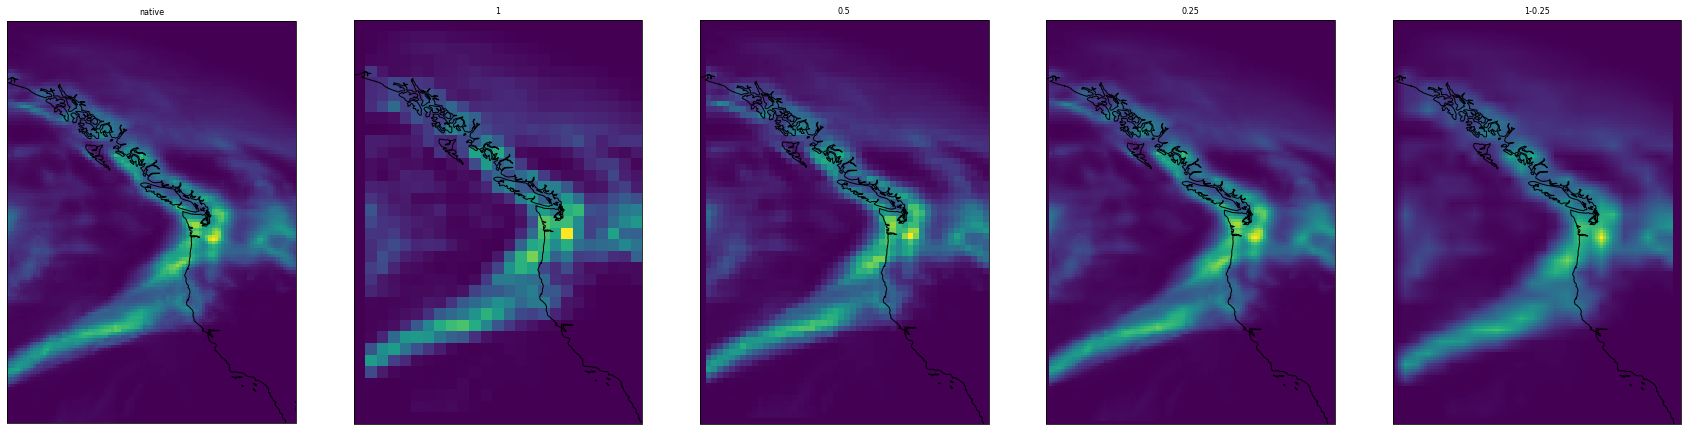

In [225]:
# make little maps
fig, axes = plt.subplots(1, 5, figsize=(30, 10), subplot_kw={'projection': ccrs.PlateCarree()})
source_domain['pr'].isel(time=0).plot.pcolormesh(ax=axes[0], add_colorbar=False);  
axes[0].coastlines();
axes[0].set_title("native", fontsize=8)
for i, key in enumerate(outputs):
    outputs[key].isel(time=0).plot.pcolormesh(ax=axes[i+1], add_colorbar=False);  
    axes[i+1].coastlines();
    axes[i+1].set_title(str(key), fontsize=8)

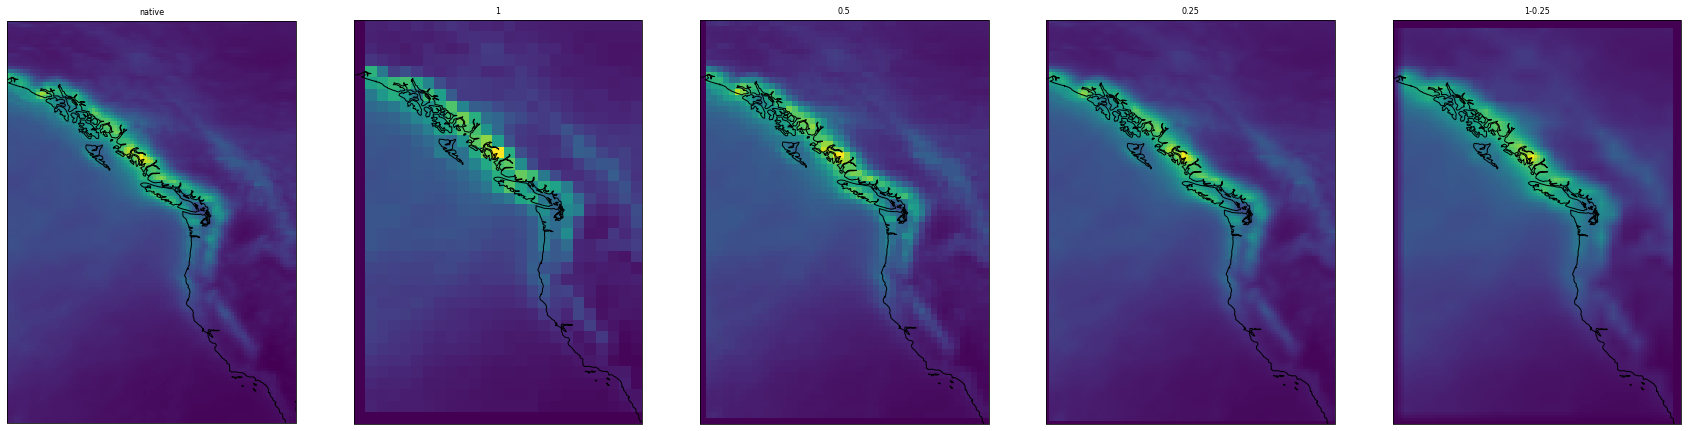

In [243]:
# same but with the first year total rainfall
fig, axes = plt.subplots(1, 5, figsize=(30, 10), subplot_kw={'projection': ccrs.PlateCarree()})
source_domain['pr'].groupby('time.year').sum().isel(year=0).plot.pcolormesh(ax=axes[0], add_colorbar=False);  
axes[0].coastlines();
axes[0].set_title("native", fontsize=8)
for i, key in enumerate(outputs):
    outputs[key].groupby('time.year').sum().isel(year=0).plot.pcolormesh(ax=axes[i+1], add_colorbar=False);  
    axes[i+1].coastlines();
    axes[i+1].set_title(str(key), fontsize=8)

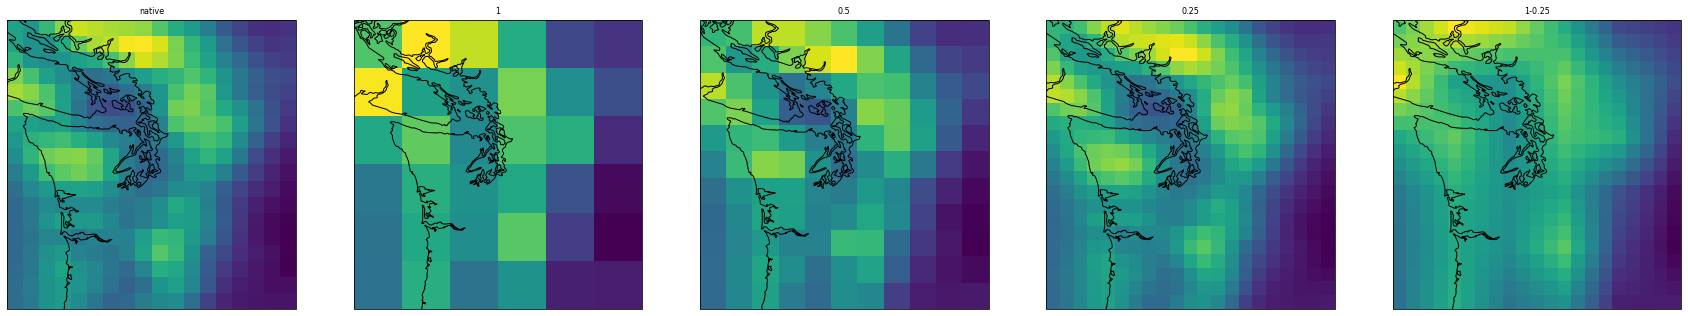

In [247]:
# zoom in 
fig, axes = plt.subplots(1, 5, figsize=(30, 10), subplot_kw={'projection': ccrs.PlateCarree()})
source_domain['pr'].groupby('time.year').sum().isel(year=0).sel(lat=slice(50, 45), lon=slice(235, 240)).plot.pcolormesh(ax=axes[0], add_colorbar=False);  
axes[0].coastlines();
axes[0].set_title("native", fontsize=8)
for i, key in enumerate(outputs):
    outputs[key].groupby('time.year').sum().isel(year=0).sel(lat=slice(45, 50), lon=slice(235, 240)).plot.pcolormesh(ax=axes[i+1], add_colorbar=False);  
    axes[i+1].coastlines();
    axes[i+1].set_title(str(key), fontsize=8)

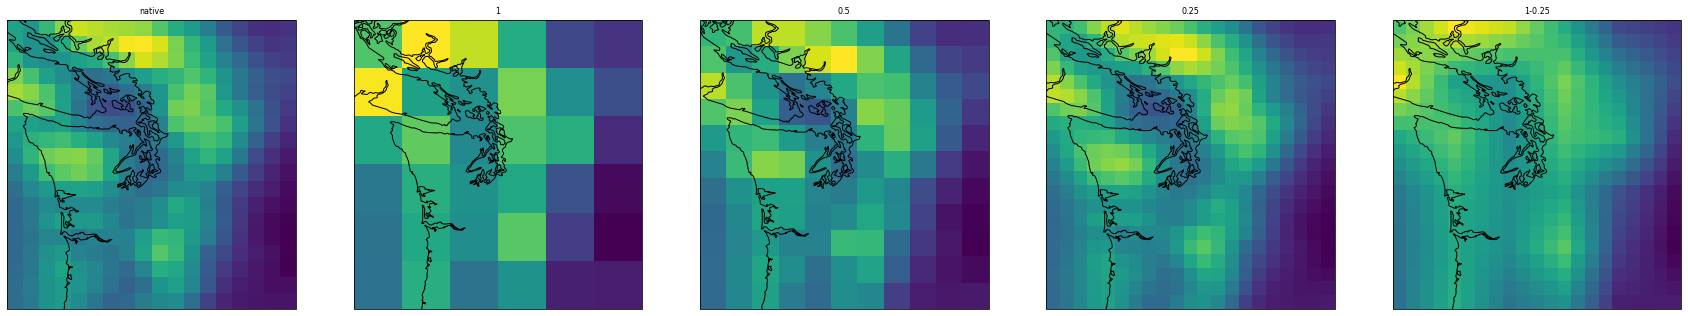

In [242]:
# zoom in, first year
fig, axes = plt.subplots(1, 5, figsize=(30, 10), subplot_kw={'projection': ccrs.PlateCarree()})
source_domain['pr'].groupby('time.year').sum().isel(year=0).sel(lat=slice(50, 45), lon=slice(235, 240)).plot.pcolormesh(ax=axes[0], add_colorbar=False);  
axes[0].coastlines();
axes[0].set_title("native", fontsize=8)
for i, key in enumerate(outputs):
    outputs[key].groupby('time.year').sum().isel(year=0).sel(lat=slice(45, 50), lon=slice(235, 240)).plot.pcolormesh(ax=axes[i+1], add_colorbar=False);  
    axes[i+1].coastlines();
    axes[i+1].set_title(str(key), fontsize=8)

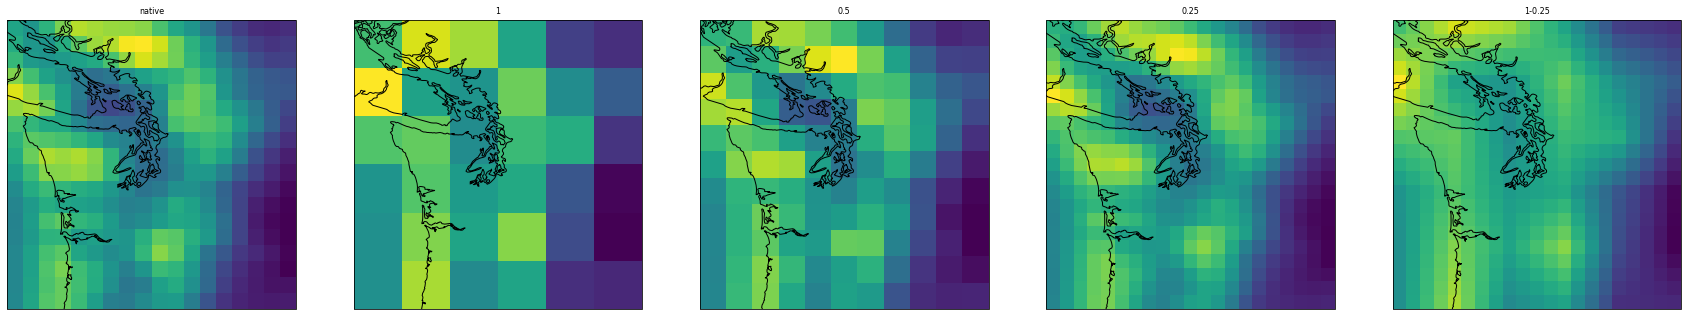

In [244]:
# zoom in, fifth year
fig, axes = plt.subplots(1, 5, figsize=(30, 10), subplot_kw={'projection': ccrs.PlateCarree()})
source_domain['pr'].groupby('time.year').sum().isel(year=4).sel(lat=slice(50, 45), lon=slice(235, 240)).plot.pcolormesh(ax=axes[0], add_colorbar=False);  
axes[0].coastlines();
axes[0].set_title("native", fontsize=8)
for i, key in enumerate(outputs):
    outputs[key].groupby('time.year').sum().isel(year=4).sel(lat=slice(45, 50), lon=slice(235, 240)).plot.pcolormesh(ax=axes[i+1], add_colorbar=False);  
    axes[i+1].coastlines();
    axes[i+1].set_title(str(key), fontsize=8)

In [227]:
# now get Seattle timeseries from each of these ERA-5 versions.
# two of the datasets have [0,360] ranging longitude, need to convert. 
outputs_around_seattle = {}
for key, val in outputs.items():
    outputs_around_seattle[key] = val.sel(lon=lon360(target_lon), lat=target_lat, method="nearest").load()

Text(0.5, 1.0, 'Seattle annual precip, various manual regridding from "native" ERA-5')

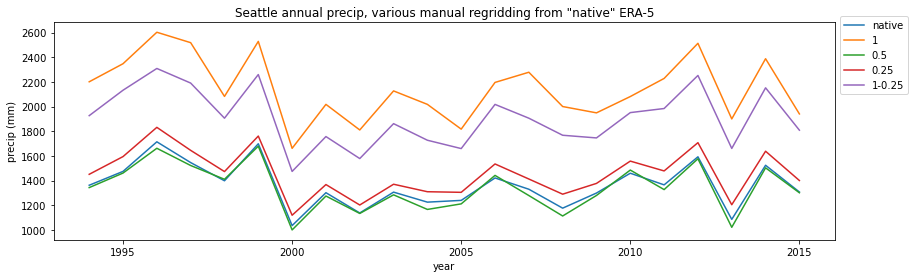

In [228]:
plt.figure(figsize=(14, 4))
source_domain['pr'].sel(lon=lon360(target_lon), lat=target_lat, method="nearest").load().groupby('time.year').sum().plot(label='native')
for key, val in outputs_around_seattle.items():
        val.groupby('time.year').sum().plot(label=key)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.ylabel('precip (mm)')
plt.title('Seattle annual precip, various manual regridding from "native" ERA-5')
# manual_bilinear_regrid_around_seattle_1_by_1.groupby('time.year').sum().plot(label='manual bilinear regridding  1 X 1')
# pr_seattle_pipeline.groupby('time.year').sum().plot(label='our pipeline, cleaned, no regridding')
# pr_seattle_pipeline_coarse.groupby('time.year').sum().plot(label='our pipeline, coarse regridding ')
# pr_seattle_pipeline_fine.groupby('time.year').sum().plot(label='our pipeline, fine regridding ')
# plt.legend(bbox_to_anchor=(1.1, 1.05))
# plt.ylabel('precip (mm)')
# plt.title('Seattle annual precip (everything wet-day corrected)')